# Exam 

### Imports

In [17]:
from quantkit import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
plt.style.use('tableau-colorblind10')

## Simulation


### Global Parameters

In [18]:
# -----------------------------
# Time evolution
# -----------------------------

t_start   = 0
t_end     = 200
timesteps = 1000

# -----------------------------
# Rydberg Chain
# -----------------------------

Omega = -1. 
delta = -1.5
Delta = .3*Omega
L     = 12
dA    = 2**6
dB    = 2**6

# -----------------------------
# Schwinger Model
# -----------------------------

w     = -Omega
m     = -delta
J     = 15*w
alpha = -0.49
L_s   = 12

# -----------------------------
# Initial states
# -----------------------------

# Rydberg
P      = blockade_projection_matrix(L)
psi0_r = generate_initial_state(L, model = 'rydberg', kind='q-q-bar-bare')
psi0_r = P @ psi0_r
psi0_r /= np.linalg.norm(psi0_r)

# Schwinger
psi0_s = generate_initial_state(L_s, model = 'schwinger', kind='q-q-bar-bare')

### Hamiltonians and Diagonalization

In [19]:
# Rydberg
L_eff = P.shape[0]
H_FSS = P @ Compute_H_FSS_sparse(Omega, delta, L, Delta) @ P.T
H_FSS = H_FSS.toarray()
e_vals_r, e_vecs_r = np.linalg.eigh(H_FSS)
C_r   = np.ravel(e_vecs_r.conj().T @ psi0_r)

# Schwinger
H_sch = Compute_H_schwinger_sparse(w, m, J, alpha, L_s).todense()
e_vals_s, e_vecs_s = np.linalg.eigh(H_sch)
C_s   = np.ravel(e_vecs_s.conj().T @ psi0_s)

In [20]:
# -----------------------------
# Save Rydberg data for later analysis
# -----------------------------

# Eigenvalues, eigenvectors and coefficients
np.save("rydberg_evals.npy", e_vals_r)           # shape (dim,)
np.save("rydberg_evecs.npy", e_vecs_r)           # shape (dim, dim)
np.save("rydberg_coeffs.npy", C_r)               # shape (dim,)

# Projector (needed for entropy calculation)
with open("projector_P.pkl", "wb") as f:
    pickle.dump(P, f)

# Bipartition dimensions (for entropy)
np.save("rydberg_dA.npy", np.array(dA))
np.save("rydberg_dB.npy", np.array(dB))

### Time Evolution

In [21]:
t_vals = np.linspace(t_start, t_end, timesteps)

# Function to produce |psi(t)> arrays
psi_t_r_list = [np.ravel(psi_t(t, e_vals_r, e_vecs_r, C_r, normalize=True)) for t in t_vals]
psi_t_s_list = [np.ravel(psi_t(t, e_vals_s, e_vecs_s, C_s, normalize=True)) for t in t_vals]

# -----------------------------
# ### Observables
# -----------------------------

# Rydberg
n_ops_r = [P @ op @ P.T for op in n_operators_by_site(L)]
E_ops_r = [P @ op @ P.T for op in E_operators_by_site(L)]
rho_r   = [P @ op @ P.T for op in matter_density_by_site(L, model='QLM')]

# Schwinger
n_ops_s = n_operators_by_site(L_s)
E_ops_s = E_operators_by_site_schwinger(L_s, alpha)
rho_s = matter_density_by_site(L_s, model='schwinger')

### Model Comparison

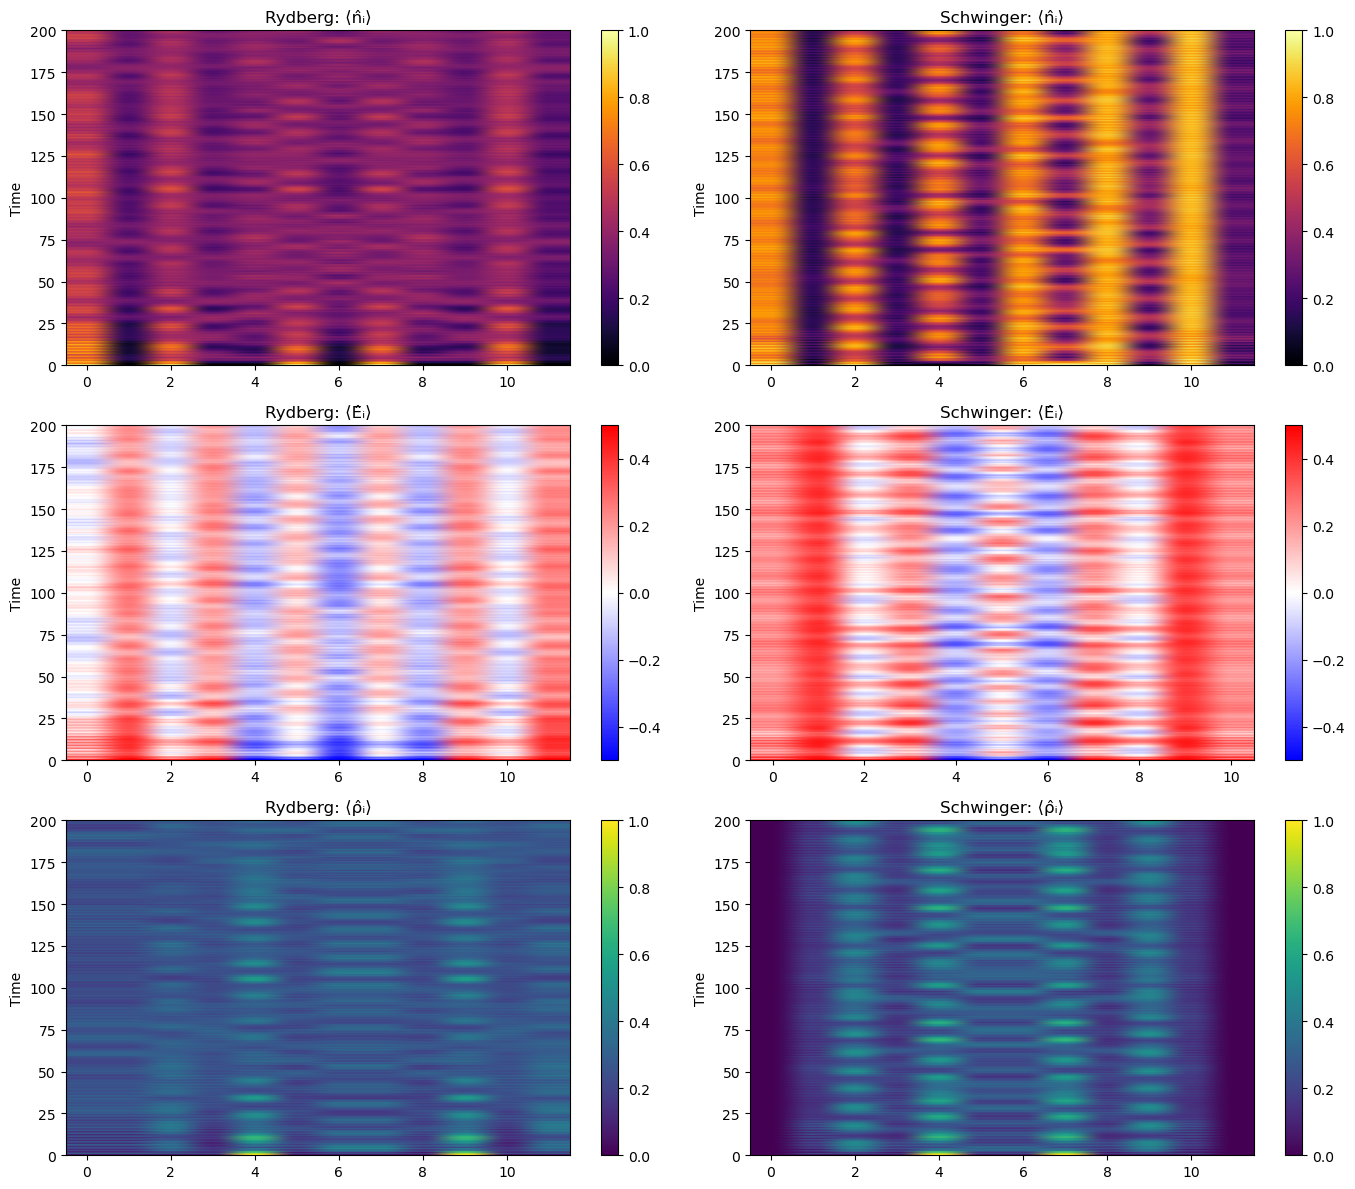

In [22]:
models        = ["Rydberg", "Schwinger"]
psi_t_lists   = [psi_t_r_list, psi_t_s_list]
n_ops_lists   = [n_ops_r, n_ops_s]
E_ops_lists   = [E_ops_r, E_ops_s]
rho_ops_lists = [rho_r, rho_s]

results = compute_model_expectations(
    models=["Rydberg", "Schwinger"],
    psi_t_lists=psi_t_lists,
    n_ops_lists=n_ops_lists,
    E_ops_lists=E_ops_lists,
    rho_ops_lists=rho_ops_lists
)

plot_model_expectations(results, t_vals)


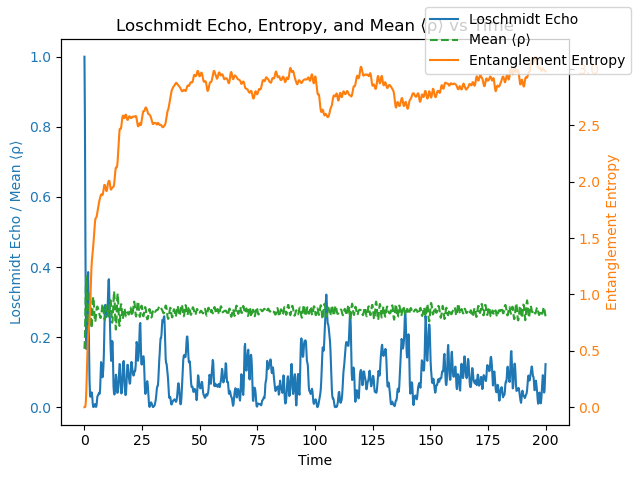

In [23]:
rho_expect_r = results["Rydberg"]["rho"]
echo = compute_echo(psi_t_r_list, psi0_r)
entropy = compute_entropy(psi_t_r_list, P.T, dA, dB)

plot_echo_entropy(t_vals, echo, entropy, rho_expect_r)

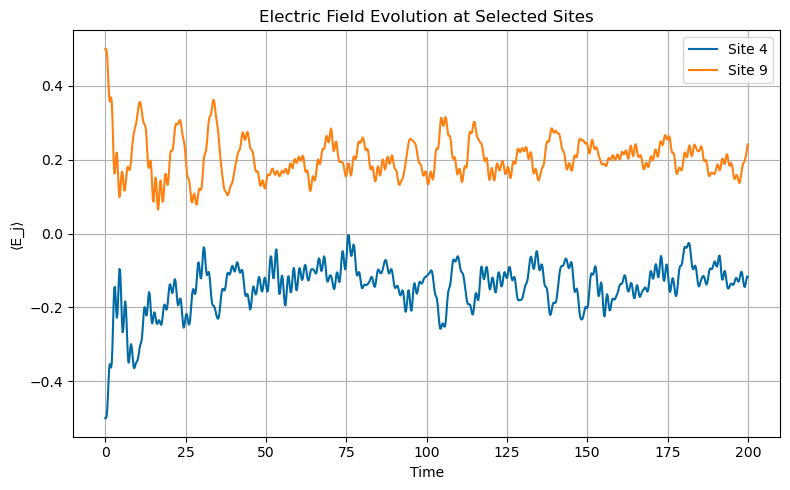

In [24]:
E_expect_r = results["Rydberg"]["E"]
sites = (4,9)
plot_electric_field(t_vals, E_expect_r, sites)

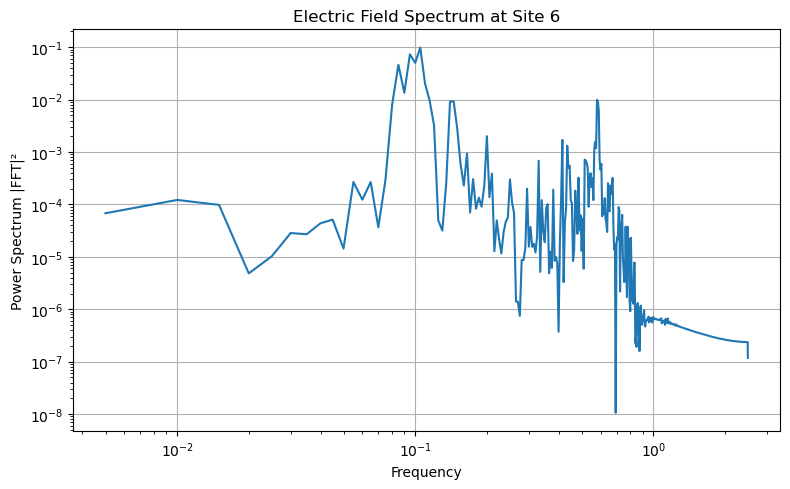

In [25]:
freqs, spectrum = compute_fft(t_vals, results["Rydberg"]["E"])

# Plot
plot_fft(freqs, spectrum, observable_name="Electric Field", site_index=6)

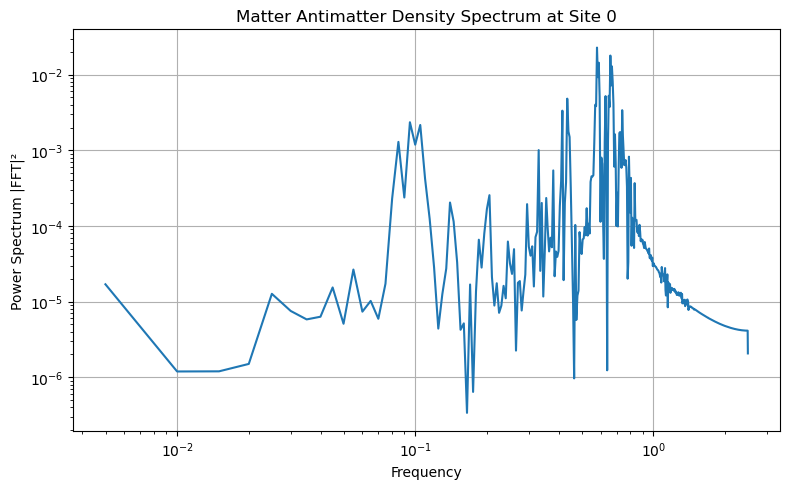

In [26]:
freqs, spectrum = compute_fft(t_vals, results["Rydberg"]["rho"])

# Plot
plot_fft(freqs, spectrum, observable_name="Matter Antimatter Density", site_index=0)

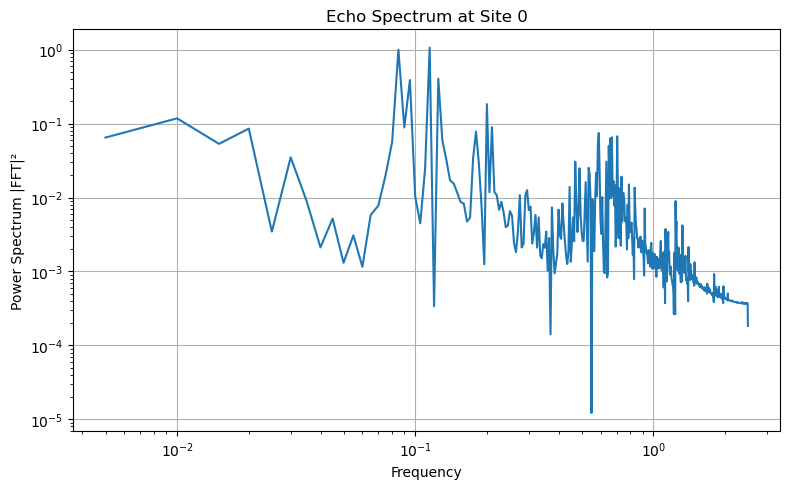

In [27]:
freqs, spectrum = compute_fft(t_vals, echo)

# Plot
plot_fft(freqs, spectrum, observable_name="Echo", site_index=0)

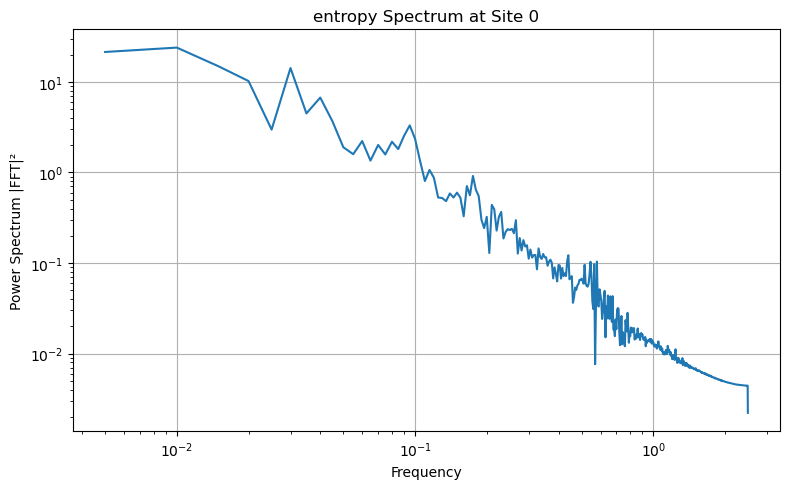

In [28]:
freqs, spectrum = compute_fft(t_vals, entropy)

# Plot
plot_fft(freqs, spectrum, observable_name="entropy", site_index=0)

### Other Plots

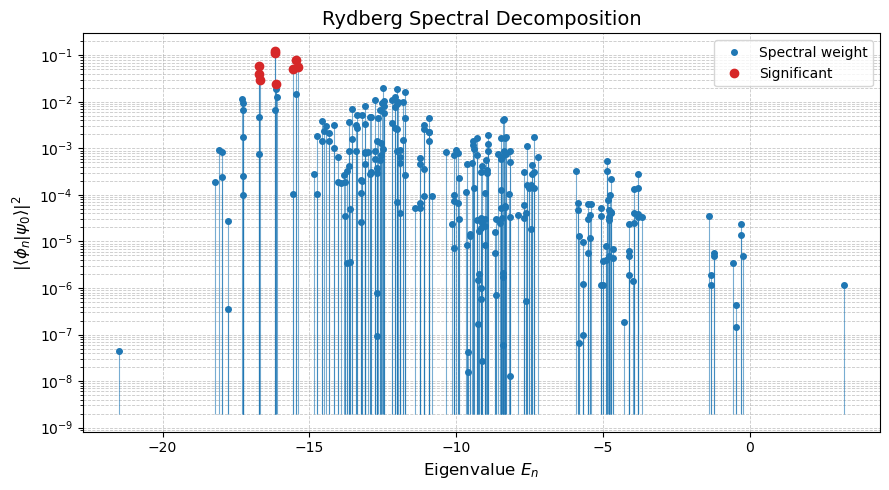

In [29]:
prob_r = np.abs(C_r)**2

# Apply mask directly without sorting
mask = prob_r >= 1.e-9
e_masked = np.array(e_vals_r)[mask]
p_masked = np.array(prob_r)[mask]

plt.figure(figsize=(9,5))

# Stem-like plot
plt.vlines(e_masked, ymin=2e-9, ymax=p_masked, color="tab:blue", alpha=0.6, linewidth=0.8)
plt.plot(e_masked, p_masked, "o", markersize=4, color="tab:blue", label="Spectral weight")

# Highlight significant overlaps
threshold = 2.e-2
mask_sig = p_masked > threshold
plt.plot(e_masked[mask_sig], p_masked[mask_sig], "o", markersize=6, color="tab:red", label="Significant")

# Labels and formatting
plt.xlabel(r"Eigenvalue $E_n$", fontsize=12)
plt.ylabel(r"$|\langle \phi_n | \psi_0 \rangle|^2$", fontsize=12)
plt.title("Rydberg Spectral Decomposition", fontsize=14)
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend()
plt.tight_layout()

plt.show()


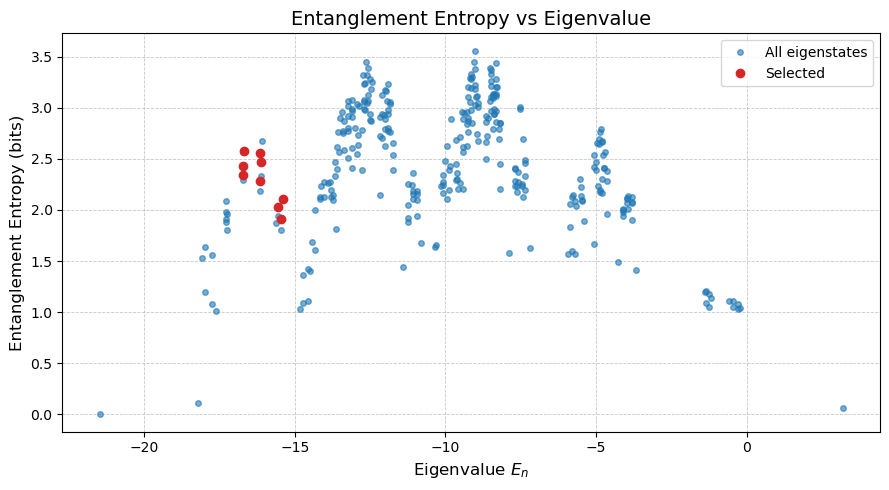

In [30]:
# 1. Compute entropy for ALL eigenstates
all_psi_list = [e_vecs_r[:, i] for i in range(e_vecs_r.shape[1])]
entropy_all = compute_entropy(all_psi_list, projector=P.T, dA=dA, dB=dB)
entropy_masked = (entropy_all[mask])[mask_sig]
# 2. Plot entropy vs eigenvalue for all states
plt.figure(figsize=(9,5))
plt.plot(e_vals_r, entropy_all, "o", color="tab:blue", markersize=4, alpha=0.6, label="All eigenstates")

# 3. Highlight selected subset
plt.plot(e_masked[mask_sig], entropy_masked, "o", color="tab:red", markersize=6, label="Selected")

# Labels and formatting
plt.xlabel(r"Eigenvalue $E_n$", fontsize=12)
plt.ylabel("Entanglement Entropy (bits)", fontsize=12)
plt.title("Entanglement Entropy vs Eigenvalue", fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


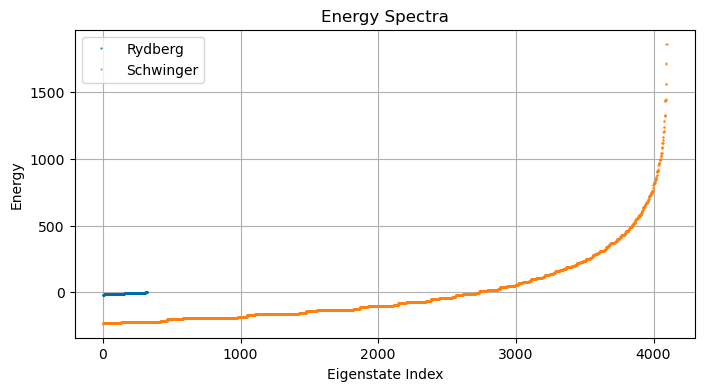

In [31]:
# Energy spectra
plt.figure(figsize=(8,4))
plt.plot(np.sort(e_vals_r), '.', markersize=1, label="Rydberg")
plt.plot(np.sort(e_vals_s), '.', markersize=1, label="Schwinger")
plt.title("Energy Spectra")
plt.xlabel("Eigenstate Index")
plt.ylabel("Energy")
plt.legend()
plt.grid(True)
plt.show()
